# Activation Functions

In D.L., our **objective** is, almost always, to find a **set of weights** that **minimizes error.** All of these sets of weights are **linear operations** and hence, if performed alone, we would attain just a simple **multiple linear regression model.** 

##### What’s the Problem with Linear Models?

If inputs are left untouched, they are not **flexible** as they can only model linear relationships while most data out there has a **non-linear patterns.** Hence, we need to find a way to force our model to be able to **learn non-linear patterns.** 

##### How do we do this?

After a set of linear operations, we apply to the new **input** created by the linear operations ($Ax = \hat{y}$) a **non-linear activation function**.

Suppose we have a simple linear model $\hat{y}=ax+b$. These $\hat{y}$ form a linear operation such as below:



Well, given our orange line ($\hat{y}$), we then apply a **non-linear activation function** so as to **transform** our linear model into a **fixed non-linear model** such as below:

<img src="https://www.researchgate.net/profile/Hoon_Chung2/publication/309775740/figure/fig1/AS:538049215381504@1505292337270/The-most-common-nonlinear-activation-functions.png" alt="The most common nonlinear activation functions. | Download ..." style="zoom: 50%;" />

**Why is this a fixed non-linear operation?**

Because whatever formula we use for our non-linear operation, **we do NOT** have a set of weights on it that try to learn an optimal non-linear representation. It will always follow a **fixed, single transformation.**

##### Well, isn’t our purpose to find an optimal non-linear operation?

Yes and no. We find an optimal non-linear operation by letting our set of **linear weights** learn a **representation of the data** that, **once fed to the non-linear operation**, will **correctly identify the new pattern.** Hence, the objective of our linear weights now becomes to **find a representation of the data that, once fed to the non-linear activation, will correctly learn the non-linear patterns.**

##### How do we backpropagate these non-linear activations?

Given that these non-linear activations are in fact non-linear, we are unable to just take the input as the gradient as we can do with linear operations (3x => 3). Hence, we will need **two things**:

1. The **input ($\hat{y}$) that was fed to the non-linear activation** and
2. The **derivative equation of the non-linear function.**

Given that we want to apply the non-linear operation to every input, we can classify these operations as element-wise. 

This has important implications on how we can calculate our gradient. 

**First**, as we learned on the "Linear Layer" tutorial, the dimension of the incoming gradient from our subsequent operation will equal the dimension of the output from our non-linear operation. 

Now, since the output of the non-linear operations equals the dimension of the input, we are able to calculate the corresponding chain-gradient with a simple Hadamard product (element-wise multiplication) between our incoming gradient and our current non-linear operation. In other words,

```input.shape == output.shape == incoming_grad.shape```

**Second**, given that there are no weight parameters to these operations holds two implications:

i) from a backward perspective, these operations are only intermediate variables and 

ii) we can just apply the derivative of the equation to each input such as shown below

$$z = \sigma(y)=\sigma(x_ow_0+x_1w_1+x_2w_2+x_3w_3) = \sigma(x_ow_0)+\sigma(x_1w_1)+\sigma(x_2w_2)+\sigma(x_3w_3)$$

Hence

$$\frac{\partial z}{\partial y} = \frac{\partial z}{\partial y}(x_ow_0+x_1w_1+x_2w_2+x_3w_3) = \frac{\partial z}{\partial y}(x_ow_0)+\frac{\partial z}{\partial y}(x_1w_1)+\frac{\partial z}{\partial y}(x_2w_2)+\frac{\partial z}{\partial y}(x_3w_3)$$

Now that we generally understand how to implement non-linear operations, it begs to ask, **what are some common non-linear operations?**

Some common activation functions are shown below:

* ReLU
* Hyperbolic Tangent (tanh)
* Leaky ReLU

Each has their own unique properties and usually, finding the best best corresponding non-linear activation to a model is left to trial and error.

# ReLU
In this tutorial, we will first focus on implementing the ReLU layer and towards the end, for comparison purposes, we will define alternative activation functions.

ReLU is a piece-wise linear, vector valued function that adds non-linearity to our model. The effects that this simple piece-wise function has had on the DL sphere have been astonishing. 

The ReLU's forward and backward pass can both be seen as "gates" that either inhibit or advance the flow of either operations. 

During the forward pass, ReLU either retains the original content of the input if its greater than zero or else, turns it to zero.

```python
[x if x > 0 else 0 for x in input]
```

For the inputs that were "cut" to zero, its gradients are turned to zero while the rest of the values become 1. Hence, and given that ReLU is an intermediate operation, ReLU either restricts values of the incoming gradients or lets them "flow". This process is graphed below:

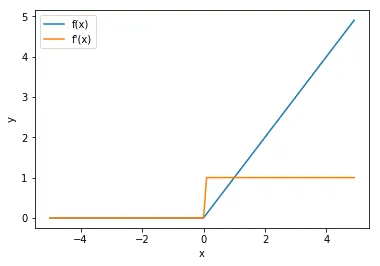

Such simple conditions make ReLU a "lightweight" operation as it does not take much to compute its forward and backward method

Such properties, and its surprising effectiveness to model non-linearity, have made ReLU a very popular choice of option for most DL architectures.

Let us model this process in PyTorch

In [1]:
import torch
import torch.nn as nn
torch.randn((2,2)).cuda()

tensor([[ 1.6169, -0.8602],
        [ 0.2214, -0.4084]], device='cuda:0')

In [2]:
# custom ReLU function 
# Remember that:
# input.shape == out.shape == incoming_gradient.shape

class ReLU_layer(torch.autograd.Function):
    
    @staticmethod
    def forward(self, input):
        # save input for backward() pass 
        self.save_for_backward(input) # wraps in a tuple structure
        activated_input = torch.clamp(input, min = 0)
        return activated_input

    @staticmethod
    def backward(self, incoming_grad):
        """
        In the backward pass we receive a Tensor containing the 
        gradient of the loss with respect to our f(x) output, 
        and we now need to compute the gradient of the loss
        wrt the input.
        """
        # keep in mind that the gradient of ReLU is binary = {0,1}
        # hence, we will either keep the element of the output_grad_wrt_loss
        # or turn it to zero
        input, = self.saved_tensors
        output_grad = incoming_grad.clone()
        output_grad[input < 0] = 0
        return output_grad 

In [3]:
# Wrap ReLU_layer function in nn.module
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

        
    def forward(self, input):
        output = ReLU_layer.apply(input)
        return output
    

In [5]:
# test function with linear + relu layer
dummy_input= torch.ones((1,2)) # input 

# forward pass
linear = nn.Linear(2,3)
relu = ReLU()
linear2 = nn.Linear(3,1)

output1 = linear(dummy_input)
output2 = relu(output1)
output3 = linear2(output2)
output3

tensor([[0.2316]], grad_fn=<AddmmBackward>)

In [6]:
# backward pass
output3.backward()

In [7]:
# check computed gradients of 1st linear layaer
list(linear.parameters())[0].grad

tensor([[0.1558, 0.1558],
        [0.0000, 0.0000],
        [0.0000, 0.0000]])

# MNIST

Now that we have validated our operation, let's us apply ReLU to the MNIST dataset by building a standard neural network with the following linear parameters:

```[128, 64, 10]```

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, num_units = 128, activation = ReLU()):
        super().__init__()
        
        # fully-connected layers
        self.fc1 = nn.Linear(784,num_units)
        self.fc2 = nn.Linear(num_units , num_units//2)
        self.fc3 = nn.Linear(num_units // 2, 10)
        
        # init activation
        self.activation = activation
        
    def forward(self,x):
        
        # 1st layer
        output = self.activation(self.fc1(x))
        
        # 2nd layer
        output = self.activation(self.fc2(output))
        
        # 3rd layer
        output = self.fc3(output)
        
        # output.shape = (B, 10)
        return output
        

In [5]:
# instantiate model and feed it to GPU
device = torch.device('cuda')
model = NeuralNet().to(device)
model

NeuralNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (activation): ReLU()
)

In [6]:
# define optimizer
from torch import optim
optimizer = optim.SGD(model.parameters(), lr = .01)

In [7]:
# define criterion
criterion = nn.CrossEntropyLoss()

In [201]:
# import training MNIST dataset
import torchvision
from torchvision import transforms
import numpy as np
from torch.utils.data import DataLoader
from torchvision.utils import make_grid 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

root = r'C:\Users\erick\PycharmProjects\untitled\3D_2D_GAN\MNIST_experimentation'
train_mnist = torchvision.datasets.MNIST(root = root, 
                                      train = True, 
                                        transform = transforms.ToTensor(),
                                      download = False, 
                                  )

train_mnist.data.shape

torch.Size([60000, 28, 28])

In [202]:
# import evaluation MNIST dataset

eval_mnist = torchvision.datasets.MNIST(root = root, 
                                      train = False,
                                      transform = transforms.ToTensor(),
                                      download = False, 
                                  )
eval_mnist.data.shape

torch.Size([10000, 28, 28])

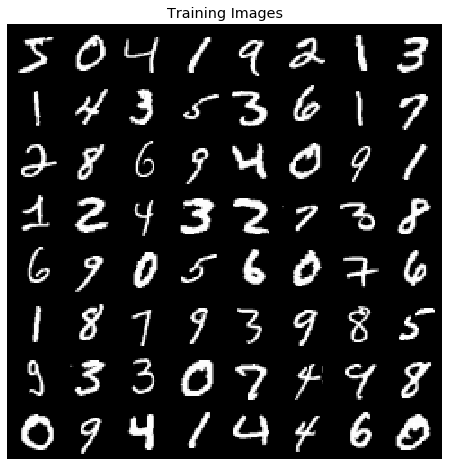

In [203]:
# visualize data
# visualize our data

grid_images = np.transpose(make_grid(train_mnist.data[:64].unsqueeze(1)), (1,2,0))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid_images,cmap = 'gray')

In [10]:
# normalize data
train_mnist.data = (train_mnist.data.float() - train_mnist.data.float().mean()) / train_mnist.data.float().std()
eval_mnist.data = (eval_mnist.data.float() - eval_mnist.data.float().mean()) / eval_mnist.data.float().std()

In [11]:
# parse data to batches of 128

# pin_memory = True if you have CUDA. It will speed up I/O

train_dl = DataLoader(train_mnist, batch_size = 64, 
                      shuffle = True, pin_memory = True)

eval_dl = DataLoader(eval_mnist, batch_size = 128, 
                      shuffle = True, pin_memory = True)


batch_images, batch_labels = next(iter(train_dl))
print(f"batch_images.shape: {batch_images.shape}")
print('-'*50)
print(f"batch_labels.shape: {batch_labels.shape}")

batch_images.shape: torch.Size([64, 1, 28, 28])
--------------------------------------------------
batch_labels.shape: torch.Size([64])


# Train Neural Net

In [12]:
# compute average accuracy of batch

def accuracy(pred, labels):
    # predictions.shape = (B, 10)
    # labels.shape = (B)
    
    n_batch = labels.shape[0]
    
    # extract idx of max value from our batch predictions
    # predicted.shape = (B)
    _, preds = torch.max(pred, 1)
    
    
    # compute average accuracy of our batch
    compare = (preds == labels).sum()
    return compare.item() / n_batch
    
    

In [119]:

def train(model, iterator, optimizer, criterion):
    
    # hold avg loss and acc sum of all batches
    epoch_loss = 0
    epoch_acc = 0
    
    
    for batch in iterator:
        
        # zero-out all gradients (if any) from our model parameters
        model.zero_grad()
        
        
        # extract input and label
        
        # input.shape = (B, 784), "flatten" image
        input = batch[0].view(-1,784).cuda().float() # shape: (B, 784), "flatten" image
        # label.shape = (B)
        label = batch[1].cuda()
        
        
        # Start PyTorch's Dynamic Graph
        
        # predictions.shape = (B, 10)
        predictions = model(input)
        
        # average batch loss 
        loss = criterion(predictions, label)
        
        # calculate grad(loss) / grad(parameters)
        # "clears" PyTorch's dynamic graph
        loss.backward()
        
        
        # perform SGD "step" operation
        optimizer.step()
        
        
        # Given that PyTorch variables are "contagious" (they record all operations)
        # we need to ".detach()" to stop them from recording any performance
        # statistics
        
        
        # average batch accuracy
        acc = accuracy(predictions.detach(), label)
        
        # record our stats
        epoch_loss += loss.detach()
        epoch_acc += acc
        
    # NOTE: tense.item() unpacks Tensor item to a regular python object 
    # tense.tensor([1]).item() == 1
        
    # return average loss and acc of epoch
    return epoch_loss.item() / len(iterator), epoch_acc / len(iterator)


In [47]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
        
    # turn off grad tracking as we are only evaluation performance
    with torch.no_grad():
    
        for batch in iterator:

            # extract input and label       
            input = batch[0].view(-1,784).cuda()
            label = batch[1].cuda()


            # predictions.shape = (B, 10)
            predictions = model(input)

            # average batch loss 
            loss = criterion(predictions, label)

            # average batch accuracy
            acc = accuracy(predictions, label)

            epoch_loss += loss
            epoch_acc += acc
        
    return epoch_loss.item() / len(iterator), epoch_acc / len(iterator)

In [15]:
import time

# record time it takes to train and evaluate an epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time # total time
    elapsed_mins = int(elapsed_time / 60) # minutes
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60)) # seconds
    return elapsed_mins, elapsed_secs

In [35]:
N_EPOCHS = 25

# track statistics
track_stats = {'activation': [],
               'epoch': [],
               'train_loss': [],
              'train_acc': [],
              'valid_loss':[],
              'valid_acc':[]}


best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, eval_dl, criterion)
    
    end_time = time.time()
    
    # record operations
    track_stats['activation'].append('ReLU')
    track_stats['epoch'].append(epoch + 1)
    track_stats['train_loss'].append(train_loss)
    track_stats['train_acc'].append(train_acc)
    track_stats['valid_loss'].append(valid_loss)
    track_stats['valid_acc'].append(valid_acc)
    
    

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if this was our best performance, record model parameters
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_linear_relu_params.pt')
    
    # print out stats
    print('-'*75)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


---------------------------------------------------------------------------
Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 2.257 | Train Acc: 19.67%
	 Val. Loss: 2.208 |  Val. Acc: 11.47%
---------------------------------------------------------------------------
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 1.928 | Train Acc: 35.99%
	 Val. Loss: 2.658 |  Val. Acc: 15.09%
---------------------------------------------------------------------------
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 1.684 | Train Acc: 45.90%
	 Val. Loss: 2.697 |  Val. Acc: 18.07%
---------------------------------------------------------------------------
Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 1.530 | Train Acc: 50.23%
	 Val. Loss: 3.533 |  Val. Acc: 16.05%
---------------------------------------------------------------------------
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 1.444 | Train Acc: 51.98%
	 Val. Loss: 3.861 |  Val. Acc: 16.42%
---------------------------------------------------------------------------

# Visualization

From the above, we can tell that our model is severely suffering from overfitting by the gap between training and validation accuracy. However, to attain a better understanding, we will graph our recorded statistics and use HiPlot, a new graphing library by Facebook, to understand the overall patterns of our model

**NOTE**: If you do not have HiPlot installed, go to their [github repo](https://github.com/facebookresearch/hiplot) to find latest installation

In [140]:
# save statistics
# track_stats = torch.load('ReLU_stats.pt')
#torch.save(track_stats, 'ReLU_stats.pt')

In [141]:
# format data 
import pandas as pd

stats = pd.DataFrame(track_stats)
stats

activation  epoch  train_loss  train_acc  valid_loss  valid_acc
0        ReLU      1    2.256706   0.196678    2.207836   0.114715
1        ReLU      2    1.928205   0.359941    2.658292   0.150910
2        ReLU      3    1.684190   0.459005    2.697213   0.180676
3        ReLU      4    1.530393   0.502265    3.532650   0.160502
4        ReLU      5    1.443833   0.519773    3.861390   0.164161
5        ReLU      6    1.393192   0.526353    4.698839   0.169699
6        ReLU      7    1.358555   0.531100    5.268126   0.163370
7        ReLU      8    1.335125   0.533765    4.952165   0.149723
8        ReLU      9    1.318727   0.538430    5.703450   0.151305
9        ReLU     10    1.303947   0.542644    5.436379   0.156448
10       ReLU     11    1.291508   0.542494    5.915389   0.157041
11       ReLU     12    1.278763   0.547708    5.347536   0.175435
12       ReLU     13    1.269061   0.550323    5.427631   0.144877
13       ReLU     14    1.257962   0.554971    5.108685   0.159711
14       ReLU     15    1.249527   0.557536    5.108813   0.151108
15       ReLU     16    1.239964   0.559968    5.530833   0.156349
16       ReLU     17    1.232409   0.563083    5.849154   0.148833
17       ReLU     18    1.224834   0.564765    5.722316   0.161294
18       ReLU     19    1.218170   0.567697    6.119403   0.173754
19       ReLU     20    1.210809   0.570496    5.578406   0.174347
20       ReLU     21    1.204878   0.572378    5.527742   0.150811
21       ReLU     22    1.198037   0.575760    5.488918   0.173655
22       ReLU     23    1.193254   0.575776    5.657108   0.169304
23       ReLU     24    1.190567   0.579608    5.608899   0.163865
24       ReLU     25    1.182364   0.581690    5.459799   0.158228

Compare training vs validation statistics

<Figure size 1296x1296 with 0 Axes>

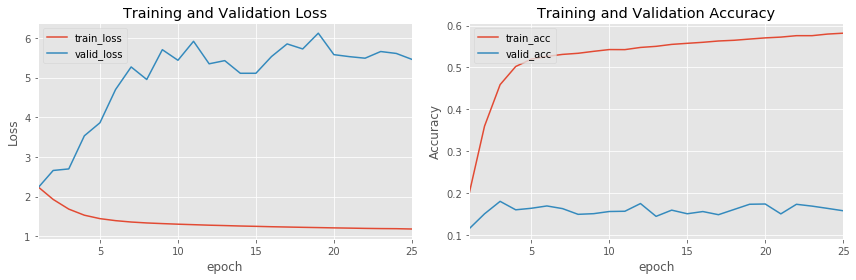

In [182]:
fig, axes = plt.subplots(nrows=1, ncols = 2,figsize = (12,4))
stats[['epoch','train_loss','valid_loss']].plot(x = 'epoch',ax=axes[0])
axes[0].title.set_text('Training and Validation Loss')
axes[0].set_ylabel('Loss')
stats[['epoch','train_acc','valid_acc']].plot(x = 'epoch',ax = axes[1])
axes[1].title.set_text('Training and Validation Accuracy')
axes[1].set_ylabel('Accuracy')
plt.tight_layout()
plt.legend(loc = 'upper left')
plt.show()

From the above, we can confidently conclude that our model is severely suffering from overfitting due to the large gap in loss and accuracy statistics.

Now, let us use HiPlot to attain a more complete picture of our model's performance

In [38]:
# organize data to hiplot format

data = []
for row in stats.iterrows():
    data.append(row[1].to_dict())
data

[{'activation': 'ReLU',
  'epoch': 1,
  'train_loss': 2.2567057985740937,
  'train_acc': 0.1966784381663113,
  'valid_loss': 2.20783610283574,
  'valid_acc': 0.11471518987341772},
 {'activation': 'ReLU',
  'epoch': 2,
  'train_loss': 1.9282052176339286,
  'train_acc': 0.3599413646055437,
  'valid_loss': 2.658291973645174,
  'valid_acc': 0.15090981012658228},
 {'activation': 'ReLU',
  'epoch': 3,
  'train_loss': 1.6841899164195762,
  'train_acc': 0.459005197228145,
  'valid_loss': 2.697213281559039,
  'valid_acc': 0.18067642405063292},
 {'activation': 'ReLU',
  'epoch': 4,
  'train_loss': 1.5303927748950559,
  'train_acc': 0.5022654584221748,
  'valid_loss': 3.5326503319076346,
  'valid_acc': 0.16050237341772153},
 {'activation': 'ReLU',
  'epoch': 5,
  'train_loss': 1.4438330806902986,
  'train_acc': 0.5197727878464818,
  'valid_loss': 3.8613895464547072,
  'valid_acc': 0.16416139240506328},
 {'activation': 'ReLU',
  'epoch': 6,
  'train_loss': 1.3931915998967217,
  'train_acc': 0.5263

In [39]:
import hiplot as hip
hip.Experiment.from_iterable(data).display(force_full_width = False)

<IPython.core.display.Javascript object>

There are numerous insights that we can gather from the above graph:

* As number of epochs increase, train loss correspondingly decreases while training accuracy increases
* However, a higher training accuracy corresponded with a high validation loss, which means that on such instances, our model's prediction on the validation set was far from the truth. 
* Further, we reached our best validation accuracy of 18% on epoch 3! This gives us insight that our model was very quick to overfit the data and hence, a lower learning rate plus an added regularization term might produce better results.

With this knowledge, we can make more informed decision on how we can "tweak" our architecture to possibly produce better results. We will perform these tweaks on our [lr and regularization]() tutorial.

# Comparison

Now, we will compare the performance of our ReLU activation function with two other activation functions:

* Tanh and
* Leaky ReLU

As was previously alluded, distinct activation functions inherit distinct properties.

As for the case of ReLU, we described its "gate" like properties. However, ReLU suffers from the "dying ReLU" problem: the input and gradient of negative inputs turn to zero, thereby making it impossible for weights that correspond to the negative input to update.

In a similar fashion, Tanh suffers from the "vanishing gradient" problem. Let us look at the graph of tanh:

$$
f(x)=\frac{ e^x-e^{-x}}{e^x+e^{-x}} \\f'(x) = 1-f(x)^2
$$


![Hyper-parameters in Action! Part I — Activation Functions](https://miro.medium.com/max/848/1*SeCBB7lfA7KPJ-T1Mi7GRg.png)



As the input infinitely diverges from zero, its gradient infinitely approximates zero. In such case, while these neurons do not become "dead," their chances of "recovering" towards a non-zero gradient to make meaningful weight changes are diminished as the input diverges from zero.

Leaky ReLU attempts to solve the "dying ReLU" problem by giving a chance for the gradients of negative inputs to "recover." Look at its below graph

$$
f(x) =\begin{cases}.01x & x < 0 \\x & x \ge 0\end{cases} \\f'(x) =\begin{cases}.01 & x < 0 \\1 & x \ge 0\end{cases}
$$


![Activation Functions | Code Odysseys](https://codeodysseys.com/posts/activation-functions/graph-activation-6.png)

As we can see, negative inputs are no longer "cut" to zero. They are just "down-weighted" by a negative slope. Usually, this is left as a parameter for the user to choose, but it is standard to have a negative slope of .01. This gives negative inputs a chance to "recover" or still remain liable to make meaningful changes to our corresponding parameters.

Figuring the optimal activation function for a model is often a matter of trial and error. Hence, we will apply the equivalent architecture as we did above but this time, we will use our newly defined activation functions.

In [16]:
################## Tanh Layer #######################

import torch.nn as nn
import torch

class tanh_layer(torch.autograd.Function):
    
    def __init__(self):
        ''
    
    def tanh(self,x):
        tanh = (x.exp() - (-x).exp()) / (x.exp() + (-x).exp())
        return tanh
    
    # forward pass
    def forward(self, input):
        # save input for backward() pass 
        self.save_for_backward(input) 
        activated_input = self.tanh(input)
        return activated_input

    # integrate backward pass with incoming_grad
    def backward(self, incoming_grad):

        input, = self.saved_tensors
        chained_grad = (1 - self.tanh(input)^2)  * incoming_grad
        return chained_grad

In [17]:
class Tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.tanh = tanh_layer()
        
    def forward(self, input):
        output = self.tanh.forward(input)
        return output
    

In [121]:
################## Leaky ReLU Layer #######################

class Leaky_ReLU_layer(torch.autograd.Function):
    
    @staticmethod
    def forward(self, input):
        # making operation in-place to tensors that hold "history" will mess up
        # the dynamic graph. Thus, clone it.
        activated_input = input.clone()
        self.save_for_backward(activated_input)
        activated_input[activated_input < 0] *= .01
        return activated_input

    @staticmethod
    def backward(self, incoming_grad):

        input, = self.saved_tensors
        output_grad = incoming_grad.clone()
        output_grad[input < 0] *= .01
        return output_grad 

In [122]:
class LeakyReLU(nn.Module):
    def __init__(self):
        super().__init__()
        ''
        
        
    def forward(self, input):
        output = Leaky_ReLU_layer.apply(input)
        return output
    

In [130]:
# instantiate models
tanh_model = NeuralNet(activation = Tanh()).to(device)
leaky_model = NeuralNet(activation = LeakyReLU()).to(device)

model = {'tanh': tanh_model,
        'leaky_relu': leaky_model}


optimizer = {'tanh': optim.SGD(tanh_model.parameters(), lr = .01),
        'leaky_relu': optim.SGD(leaky_model.parameters(), lr = .01)}



In [131]:
N_EPOCHS = 25

# track statistics
track_stats = {'activation': [],
               'epoch': [],
               'train_loss': [],
              'train_acc': [],
              'valid_loss':[],
              'valid_acc':[]}

track_stats = {'tanh': track_stats.copy(),
              'leaky_relu': track_stats.copy()} 


for activation in ['tanh','leaky_relu']:
    
    # re-initiate per activation
    best_valid_loss = float('inf')


    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss, train_acc = train(model[activation], train_dl, optimizer[activation], criterion)
        valid_loss, valid_acc = evaluate(model[activation], eval_dl, criterion)

        end_time = time.time()

        # record operations
        track_stats[activation]['activation'].append(activation)
        track_stats[activation]['epoch'].append(epoch + 1)
        track_stats[activation]['train_loss'].append(train_loss)
        track_stats[activation]['train_acc'].append(train_acc)
        track_stats[activation]['valid_loss'].append(valid_loss)
        track_stats[activation]['valid_acc'].append(valid_acc)



        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # if this was our best performance, record model parameters
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model[activation].state_dict(), 'best_'+activation+'_params.pt')

        # print out stats
        print('-'*75)
        print(f'Activation: {activation}')
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
        # if this is the last loop, save statistics
        if epoch + 1 == N_EPOCHS:
            torch.save(track_stats[activation],activation + '_stats.pt')
        



---------------------------------------------------------------------------
Activation: tanh
Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 2.135 | Train Acc: 25.89%
	 Val. Loss: 2.144 |  Val. Acc: 16.62%
---------------------------------------------------------------------------
Activation: tanh
Epoch: 02 | Epoch Time: 0m 38s
	Train Loss: 1.789 | Train Acc: 43.35%
	 Val. Loss: 2.489 |  Val. Acc: 15.23%
---------------------------------------------------------------------------
Activation: tanh
Epoch: 03 | Epoch Time: 0m 39s
	Train Loss: 1.603 | Train Acc: 49.43%
	 Val. Loss: 3.176 |  Val. Acc: 16.60%
---------------------------------------------------------------------------
Activation: tanh
Epoch: 04 | Epoch Time: 0m 39s
	Train Loss: 1.510 | Train Acc: 51.15%
	 Val. Loss: 3.610 |  Val. Acc: 16.60%
---------------------------------------------------------------------------
Activation: tanh
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 1.454 | Train Acc: 52.14%
	 Val. Loss: 3.997 |  Val. Ac

In [186]:
import pandas as pd

relu_stats = pd.DataFrame(torch.load('ReLU_stats.pt'))
tanh_stats = pd.DataFrame(track_stats['tanh'])
leaky_stats = pd.DataFrame(track_stats['leaky_relu'])
all_stats = pd.concat([relu_stats, tanh_stats, leaky_stats])
all_stats.head()

activation  epoch  train_loss  train_acc  valid_loss  valid_acc
0       ReLU      1    2.256706   0.196678    2.207836   0.114715
1       ReLU      2    1.928205   0.359941    2.658292   0.150910
2       ReLU      3    1.684190   0.459005    2.697213   0.180676
3       ReLU      4    1.530393   0.502265    3.532650   0.160502
4       ReLU      5    1.443833   0.519773    3.861390   0.164161

In [199]:
data = []

for row in all_stats.iterrows():
    data.append(row[1].to_dict())        

In [204]:
import hiplot as hip
hip.Experiment.from_iterable(data).display(force_full_width = True)

There are many insights our graph sheds light to:

* tanh and leaky ReLU attained the best validation accuracies 
* ReLU reached its best accuracy early on the process at epoch 3 while tanh and leaky ReLU reached their best performance along epochs 16 to 25. 

Just the above two insights let us know that ReLU very quickly overfits our data while tanh and leaky ReLU take more time, which is a desirable property.

Overall, if we had to choose one activation operation, we would go with tanh as it received the top two best validation accuracies.

# Conclusion

Activation functions are fundamental to any DL architecture and understanding their theory along with their implementation will make one more "aware" of the care and importance that goes on choosing the right activation function. Hopefully, it may also bring you to create your own, never before seen, activation function.

That is it for this tutorial. Thank you guys!





# Where to Next?

**Logistic Regression Tutorial:**
https://nbviewer.jupyter.org/github/Erick7451/DL-with-PyTorch/blob/master/Jupyter_Notebooks/logistic_regression.ipynb